Library Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Define path to the data directory
data_dir = Path('data/binary_split')

data_dir

WindowsPath('data/binary_split')

In [3]:
train_dir = data_dir / 'train'
print(train_dir)
test_dir = data_dir / 'test'

tumor_dir = train_dir / 'tumor'
no_tumor_dir = train_dir / 'no_tumor'
print(tumor_dir)

data\binary_split\train
data\binary_split\train\tumor


In [4]:

data_dir = Path("../data/binary_split")
train_dir = data_dir / "train"
tumor_dir = train_dir / "tumor"
no_tumor_dir = train_dir / "no_tumor"


# print("CWD:", os.getcwd())
# print("Path:", tumor_dir.resolve())
# print("Dir exists:", tumor_dir.exists())
# print("Contents:", list(tumor_dir.iterdir())[:5])

tumor_cases = list(tumor_dir.glob("*.jpg"))
no_tumor_cases = list(no_tumor_dir.glob("*.jpg"))

print(f"Tumor Cases: {len(tumor_cases)}")
print(f"No Tumor Cases: {len(no_tumor_cases)}")

# See some file names
for case in tumor_cases[:5]:
    print(case.name)


Tumor Cases: 4117
No Tumor Cases: 1595
Tr-glTr_0000.jpg
Tr-glTr_0001.jpg
Tr-glTr_0002.jpg
Tr-glTr_0003.jpg
Tr-glTr_0004.jpg


Prepping the Data

In [5]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

for img in no_tumor_cases:
    train_data.append((img, 0))  # 0 for no tumor

for img in tumor_cases:
    train_data.append((img, 1))  # 1 for tumor

print(f"Total training data: {len(train_data)}")
print("First 5 entries in train_data:" + str(train_data[:5]))
print(train_data[5][1])

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Display the first few rows of the dataframe
train_data.head()

Total training data: 5712
First 5 entries in train_data:[(WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0000.jpg'), 0), (WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0001.jpg'), 0), (WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0002.jpg'), 0), (WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0003.jpg'), 0), (WindowsPath('../data/binary_split/train/no_tumor/Tr-noTr_0004.jpg'), 0)]
0


,image,label
0,..\data\binary_split\train\tumor\Tr-pi_0716.jpg,1
1,..\data\binary_split\train\tumor\Tr-me_0104.jpg,1
2,..\data\binary_split\train\tumor\Tr-me_0788.jpg,1
3,..\data\binary_split\train\tumor\Tr-gl_0219.jpg,1
4,..\data\binary_split\train\tumor\Tr-pi_0482.jpg,1


In [6]:
train_data.shape

(5712, 2)

In [7]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

label
1    4117
0    1595
Name: count, dtype: int64


Plotting the values

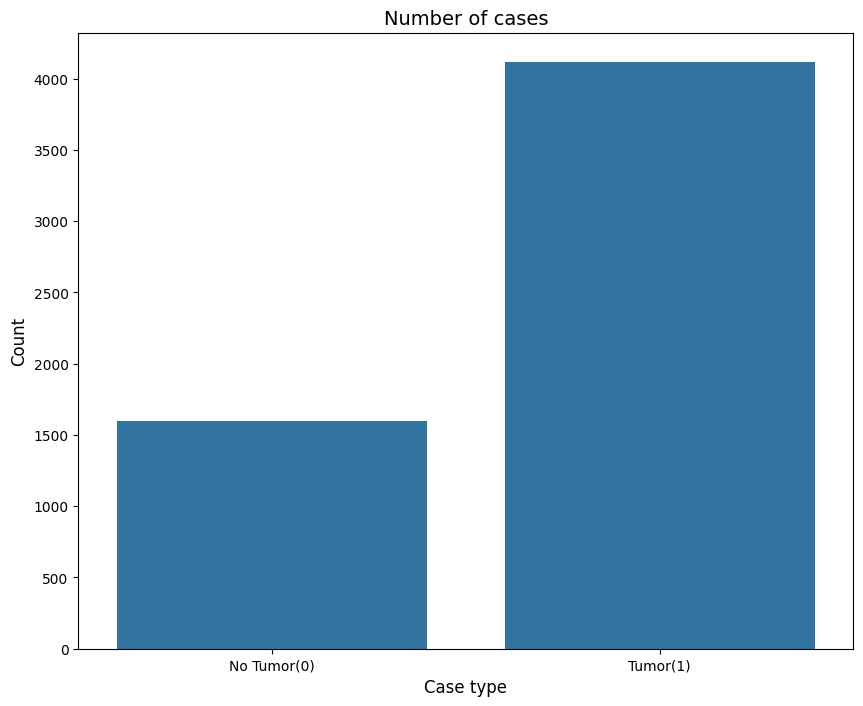

In [8]:
# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['No Tumor(0)', 'Tumor(1)'])
plt.show()

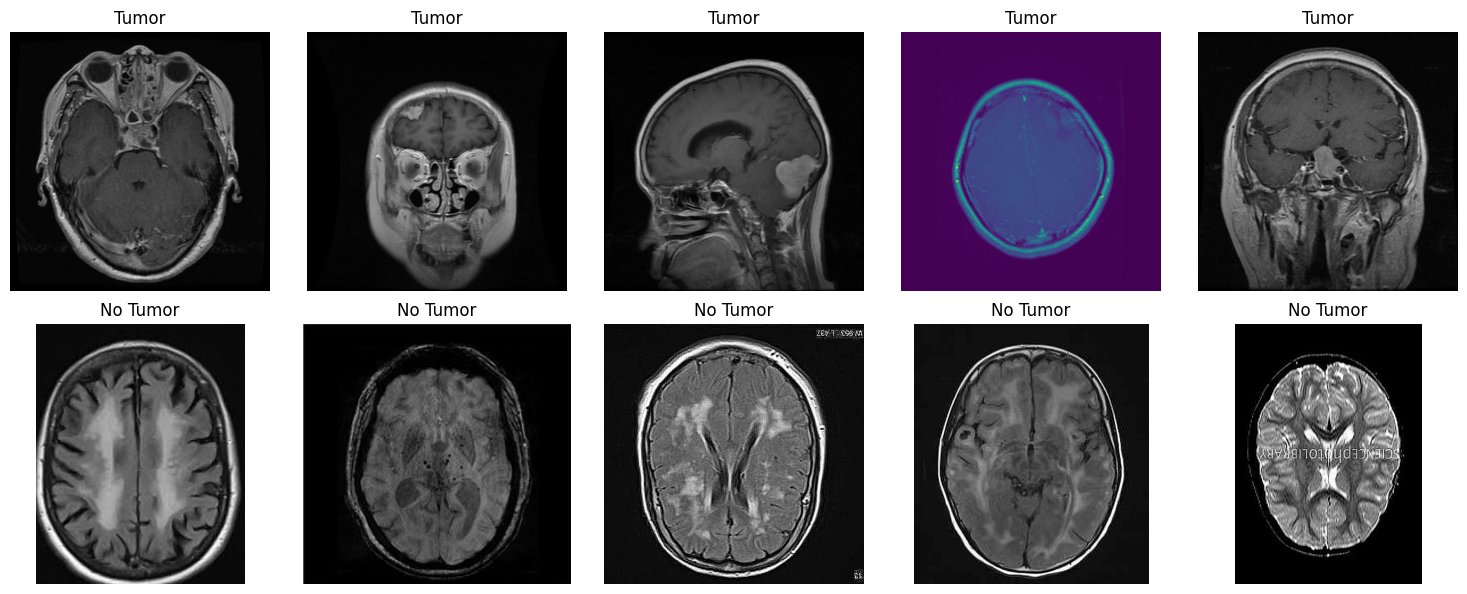

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Separate tumor and no_tumor images
tumor_images = train_data[train_data['label'] == 1]['image'].values[:5]
no_tumor_images = train_data[train_data['label'] == 0]['image'].values[:5]

plt.figure(figsize=(15, 6))

# Plot tumor images (top row)
for i, img_path in enumerate(tumor_images):
    plt.subplot(2, 5, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title("Tumor")
    plt.axis('off')

# Plot no_tumor images (bottom row)
for i, img_path in enumerate(no_tumor_images):
    plt.subplot(2, 5, i + 6)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title("No Tumor")
    plt.axis('off')

plt.tight_layout()
plt.show()


Preprocessing All Images

In [10]:
from PIL import Image

def preprocess_image(path, target_size=(28, 28)):
    """Open -> grayscale -> resize -> normalize -> add channel dim."""
    img = Image.open(path).convert('L')
    img = img.resize(target_size)
    arr = np.array(img, dtype=np.float32) / 255.0
    return arr.reshape(target_size[0], target_size[1], 1)  # (28,28,1)

# # Load image data
# X = np.array([preprocess_image(p) for p in train_data['image']])
# y = train_data['label'].values

# print("✅ Loaded image data:")
# print("X shape:", X.shape)
# print("y shape:", y.shape)


In [11]:
print(type(train_data))
print(train_data[:3])
# this step is used to convert the DataFrame into a list of tuples (image_path, label)
# where each image path is converted to a Path object for easier handling later.

train_data_list = list(zip(train_data['image'].map(Path), train_data['label']))

<class 'pandas.core.frame.DataFrame'>
                                             image  label
0  ..\data\binary_split\train\tumor\Tr-pi_0716.jpg      1
1  ..\data\binary_split\train\tumor\Tr-me_0104.jpg      1
2  ..\data\binary_split\train\tumor\Tr-me_0788.jpg      1


In [12]:
print("First 3 entries in train_data_list:" + str(train_data_list[:3]))

First 3 entries in train_data_list:[(WindowsPath('../data/binary_split/train/tumor/Tr-pi_0716.jpg'), 1), (WindowsPath('../data/binary_split/train/tumor/Tr-me_0104.jpg'), 1), (WindowsPath('../data/binary_split/train/tumor/Tr-me_0788.jpg'), 1)]


In [13]:
from tqdm import tqdm  # for progress bar

X, y = [], []
for path, label in tqdm(train_data_list, desc="Loading grayscale images"):
    img = preprocess_image(path)
    X.append(img)
    y.append(label)

X = np.array(X, dtype=np.float32)          # (N, 28, 28, 1)
y = np.array(y, dtype=np.int32)            # (N,)

print(f"✅ Loaded arrays -> X: {X.shape} | y: {y.shape} | dtype: {X.dtype}, {y.dtype}")


Loading grayscale images: 100%|██████████| 5712/5712 [01:07<00:00, 84.49it/s]

✅ Loaded arrays -> X: (5712, 28, 28, 1) | y: (5712,) | dtype: float32, int32


In [14]:
train_data_list[0][0]

WindowsPath('../data/binary_split/train/tumor/Tr-pi_0716.jpg')

Build tuple list from your DataFrame

In [15]:
assert {'image', 'label'}.issubset(set(train_data.columns)), "train_data must have columns: image, label"
train_tuples = list(zip(train_data['image'].map(Path), train_data['label'].astype(int)))
train_tuples[:3]

[(WindowsPath('../data/binary_split/train/tumor/Tr-pi_0716.jpg'), 1),
 (WindowsPath('../data/binary_split/train/tumor/Tr-me_0104.jpg'), 1),
 (WindowsPath('../data/binary_split/train/tumor/Tr-me_0788.jpg'), 1)]

In [16]:
vals, cnts = np.unique(y, return_counts=True)
print("Label distribution:", dict(zip(vals, cnts)))

Label distribution: {np.int32(0): np.int64(1595), np.int32(1): np.int64(4117)}


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print("Train:", X_train.shape, " Val:", X_val.shape)


Train: (4569, 28, 28, 1)  Val: (1143, 28, 28, 1)


In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)  
classes

array([0, 1], dtype=int32)

In [ ]:
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# below line is used to create a dictionary (object/key-value pairs) mapping class labels to their corresponding weights
# it also gives more importance to the minority class
# {0: less weight, 1: more weight} but in real it is opposite 0 has more image samples than 1
# it's standard practice to use class weights in imbalanced datasets to help the model learn better
class_weight = dict(zip(classes, weights)) 
print("Class weights:", class_weight)

Class weights: {np.int32(0): np.float64(1.790360501567398), np.int32(1): np.float64(0.6937443061038566)}


In [25]:
# ===== Step 4 — Compact CNN (28×28×1) =====
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)

tf.keras.utils.set_random_seed(42)

# (Optional) on-the-fly augmentation — applied only during training
data_augment = Sequential([
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(0.05),                        # ~±9°
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomZoom(0.05),
], name="augment")

# Input matches your grayscale preprocessed images
inp = Input(shape=(28, 28, 1), name="input_28x28x1")

# If you don’t want augmentation, set x = inp
x = data_augment(inp)

# ---- Block 1 ----
x = Conv2D(32, (3, 3), activation='relu', padding='valid', name="conv1")(x)
x = BatchNormalization(name="bn1")(x)                  # stabilizes activations
x = MaxPooling2D((2, 2), name="pool1")(x)              # downsample

# ---- Block 2 ----
x = Conv2D(64, (3, 3), activation='relu', padding='valid', name="conv2")(x)
x = BatchNormalization(name="bn2")(x)
x = MaxPooling2D((2, 2), name="pool2")(x)

# ---- Classifier head ----
x = Flatten(name="flatten")(x)
x = Dropout(0.5, name="dropout")(x)                    # combats overfitting
x = Dense(64, activation='relu', name="dense64")(x)
out = Dense(1, activation='sigmoid', name="prob")(x)   # binary prob

model = Model(inputs=inp, outputs=out, name="cnn_28x28x1")

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',                         # BCE for sigmoid
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()


Model: "cnn_28x28x1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_28x28x1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 26, 26, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 11, 11, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense64 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prob (Dense)                    │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,729 (475.50 KB)

 Trainable params: 121,537 (474.75 KB)

 Non-trainable params: 192 (768.00 B)

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

os.makedirs("api/model", exist_ok=True)
ckpt_path = "api/model/brain_mri_model.h5"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weight,    # <- from compute_class_weight on y_train
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8251 - auc: 0.8815 - loss: 0.4729

143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8259 - auc: 0.8822 - loss: 0.4712 - val_accuracy: 0.7997 - val_auc: 0.9123 - val_loss: 0.5918
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9103 - auc: 0.9565 - loss: 0.2687

143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9103 - auc: 0.9566 - loss: 0.2686 - val_accuracy: 0.7148 - val_auc: 0.9391 - val_loss: 0.5360
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9258 - auc: 0.9708 - loss: 0.2187

143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9259 - auc: 0.9708 - loss: 0.2186 - val_accuracy: 0.8198 - val_auc: 0.9526 - val_loss: 0.3978
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9251 - auc: 0.9735 - loss: 0.2074

143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9253 - auc: 0.9735 - loss: 0.2072 - val_accuracy: 0.9501 - val_auc: 0.9824 - val_loss: 0.1477
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9353 - auc: 0.9785 - loss: 0.1839 - val_accuracy: 0.9116 - val_auc: 0.9844 - val_loss: 0.2542
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9365 - auc: 0.9844 - loss: 0.1573 - val_accuracy: 0.9335 - val_auc: 0.9795 - val_loss: 0.2072
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9483 - auc: 0.9863 - loss: 0.1410 - val_accuracy: 0.9353 - val_auc: 0.9768 - val_loss: 0.1902
Epoch 8/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9496 - auc: 0.9858 - loss: 0.1474

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9497 - auc: 0.9859 - loss: 0.1471 - val_accuracy: 0.9606 - val_auc: 0.9915 - val_loss: 0.1061
Epoch 9/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9582 - auc: 0.9866 - loss: 0.1307 - val_accuracy: 0.9379 - val_auc: 0.9796 - val_loss: 0.1830
Epoch 10/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9642 - auc: 0.9897 - loss: 0.1176 - val_accuracy: 0.9659 - val_auc: 0.9914 - val_loss: 0.1121
Epoch 11/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9635 - auc: 0.9917 - loss: 0.1076 - val_accuracy: 0.9580 - val_auc: 0.9894 - val_loss: 0.1241
Epoch 12/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9664 - auc: 0.9929 - loss: 0.1001 - val_accuracy: 0.9440 - val_auc: 0.9859 - val_loss: 0.1637
Epoch 13/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9697 - auc: 0.9935 - loss: 0.0914 - val_accuracy: 0.9563 - val_auc: 0.9906 - val_loss: 0.1399
Epoch 14/30
142/143 ━━━━━━━━━━━━━━━━━━━━ 

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9669 - auc: 0.9939 - loss: 0.0914 - val_accuracy: 0.9703 - val_auc: 0.9941 - val_loss: 0.0996
Epoch 15/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9757 - auc: 0.9952 - loss: 0.0743 - val_accuracy: 0.9589 - val_auc: 0.9929 - val_loss: 0.1305
Epoch 16/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9736 - auc: 0.9950 - loss: 0.0775

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9736 - auc: 0.9950 - loss: 0.0774 - val_accuracy: 0.9633 - val_auc: 0.9919 - val_loss: 0.0974
Epoch 17/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9698 - auc: 0.9940 - loss: 0.0904

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9698 - auc: 0.9940 - loss: 0.0903 - val_accuracy: 0.9694 - val_auc: 0.9957 - val_loss: 0.0841
Epoch 18/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9748 - auc: 0.9931 - loss: 0.0930 - val_accuracy: 0.9624 - val_auc: 0.9939 - val_loss: 0.1156
Epoch 19/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9762 - auc: 0.9950 - loss: 0.0693 - val_accuracy: 0.9729 - val_auc: 0.9920 - val_loss: 0.0897
Epoch 20/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9757 - auc: 0.9955 - loss: 0.0705 - val_accuracy: 0.9711 - val_auc: 0.9929 - val_loss: 0.1082
Epoch 21/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9770 - auc: 0.9959 - loss: 0.0667 - val_accuracy: 0.9650 - val_auc: 0.9908 - val_loss: 0.1324
Epoch 22/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9803 - auc: 0.9961 - loss: 0.0620 - val_accuracy: 0.9475 - val_auc: 0.9889 - val_loss: 0.1316
Epoch 23/30
143/143 ━━━━━━━━━━━━━━━━━━━━

In [58]:
import cv2
from tensorflow.keras.models import load_model

# ---- Config ----
MODEL_PATH = "api/model/brain_mri_model.h5"
META_PATH  = "api/model/metadata.json"   # optional (for threshold + metadata)
INPUT_SIZE = (28, 28)                    # must match training
DEFAULT_THRESHOLD = 0.05                  # fallback if no metadata/best['thr']

# ---- Load model ----
model = load_model(MODEL_PATH)

# ---- Load threshold (optional) ----
if Path(META_PATH).exists():
    with open(META_PATH, "r") as f:
        meta = json.load(f)
    THRESHOLD = float(meta.get("threshold", DEFAULT_THRESHOLD))
    LABEL_MAP = meta.get("label_map", {"no_tumor": 0, "tumor": 1})
else:
    THRESHOLD = DEFAULT_THRESHOLD
    LABEL_MAP = {"no_tumor": 0, "tumor": 1}

ID2LABEL = {v: k for k, v in LABEL_MAP.items()}

def preprocess_single_cv2(path: str, size=INPUT_SIZE) -> np.ndarray:
    """
    Read image with cv2 in GRAYSCALE, resize to size, normalize to [0,1],
    and return shape (1, H, W, 1) ready for model.predict().
    """
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    arr = img.astype(np.float32) / 255.0
    arr = arr.reshape(1, size[0], size[1], 1)
    return arr

def predict_single_cv2(path: str, threshold: float = THRESHOLD):
    """
    Preprocess with cv2 (grayscale), run model, apply threshold.
    Returns: dict with probability, label_id, label_name, threshold.
    """
    x = preprocess_single_cv2(path, size=INPUT_SIZE)
    prob = float(model.predict(x, verbose=0)[0][0])   # sigmoid prob for class 'tumor' (label=1)
    label_id = int(prob >= threshold)                 # 1: tumor, 0: no_tumor
    label_name = ID2LABEL.get(label_id, str(label_id))
    return {
        "file": str(path),
        "probability": prob,
        "label_id": label_id,
        "label_name": label_name,
        "threshold": threshold
    }

model.compile()



In [ ]:
# ---- Example usage ----
# Replace with your test image path:
test_image_path = "../data/binary_split/test/no_tumor/healthy-1.jpg"  # or no_tumor/example.png
if Path(test_image_path).exists():
    res = predict_single_cv2(test_image_path)
    print(f"[RESULT]\n"
          f"  file      : {res['file']}\n"
          f"  prob(1)   : {res['probability']:.4f}\n"
          f"  threshold : {res['threshold']:.2f}\n"
          f"  predicted : {res['label_name']} (id={res['label_id']})")
else:
    print("Update 'test_image_path' to a valid image and re-run.")

[RESULT]
  file      : ../data/binary_split/test/no_tumor/healthy-1.jpg
  prob(1)   : 0.8130
  threshold : 0.05
  predicted : tumor (id=1)


In [ ]:
# ---- Convert to script ----
# !jupyter nbconvert --to script model_dev.ipynb 


[NbConvertApp] Converting notebook model_dev.ipynb to script
[NbConvertApp] Writing 10606 bytes to model_dev.py
